In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.layers import Dense , Conv2D , MaxPooling2D  , Activation , BatchNormalization , Add , Input , GlobalAveragePooling2D
from keras.models import Sequential , Model
from keras.utils import plot_model
from keras.datasets import cifar10


In [2]:
(x_train , y_train) , (x_test , y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [3]:
x_train.shape , y_train.shape , x_test.shape , y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

# * Create Identity Block *
The identity block is used to add residual connections to the network without changing the dimensions of the input. It consists of two convolutional layers with batch normalization and relu activation

In [4]:
def identity_block(x , filters):
  f1 , f2 = filters
  x_shortcut = x
  #first component of the main path
  x = Conv2D(f1 , (3,3) , strides = (1,1) , padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #second component of  main path
  x = Conv2D(f2 , (3,3) , strides = (1,1) , padding = 'same')(x)
  x = BatchNormalization()(x)

  #add shortcut connection to main path
  x = Add()([x , x_shortcut])
  x = Activation('relu')(x)
  return x

# ** Convolution Block **
The convolutional block is used to add residual connections to the network while changing the dimension (for downsampling) . It consists of 2 convolutional layers with Batch norm and relu activation & an additonal convolutional layer for shortcut connections to match dimensions.

In [5]:
def convolutional_block(x , filters , s=2):
  f1 , f2 = filters
  x_shortcut = x
  #first component of the main path
  x = Conv2D(f1 , (3,3) , strides = (s,s) , padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #second component of  main path
  x = Conv2D(f2 , (3,3) , strides = (1,1) , padding = 'same')(x)
  x = BatchNormalization()(x)

  #shortcut path
  x_shortcut = Conv2D(f2 , (1,1) , strides = (s,s) , padding = 'same')(x_shortcut)
  x_shortcut = BatchNormalization()(x_shortcut)

  #add shortcut value to main path
  x = Add()([x , x_shortcut])
  x = Activation('relu')(x)

  return x

# ***Create the Resnet Architecture***

The ResNet function defines the overall architectures, starting with an initial convolution and maxpooling multiple stages of convolutional and identity blocks.  identity block consists of three convolutional layers, each followed by batch normalization and ReLU activation functions.  it ends with a global average pooling layer and a fully connected output layer with softmax activation for classification.

In [6]:
def ResNet(input_shape,num_classses):
  inputs = Input(shape = input_shape)

  #Stage 1
  x = Conv2D(64 , (7,7) , strides = (2,2) , padding = 'same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3,3) , strides = (2,2) , padding = 'same')(x)

  #Stage 2
  x = convolutional_block(x , filters = [64,64] , s = 1)
  x = identity_block(x , filters = [64,64])

  #Stage 3
  x = convolutional_block(x , filters = [128,128] , s = 2)
  x = identity_block(x , filters = [128,128])

  #Stage 4
  x = convolutional_block(x , filters = [256,256] , s = 2)
  x = identity_block(x , filters = [256,256])

  #Stage 5
  x = convolutional_block(x , filters = [512,512] , s = 2)
  x = identity_block(x , filters = [512,512])

  #Average pooling
  x = GlobalAveragePooling2D()(x)

  #output layer
  outputs = Dense(num_classses , activation = 'softmax')(x)

  model = Model(inputs = inputs , outputs = outputs)
  return model


In [7]:
model = ResNet((32,32,3) , 10)

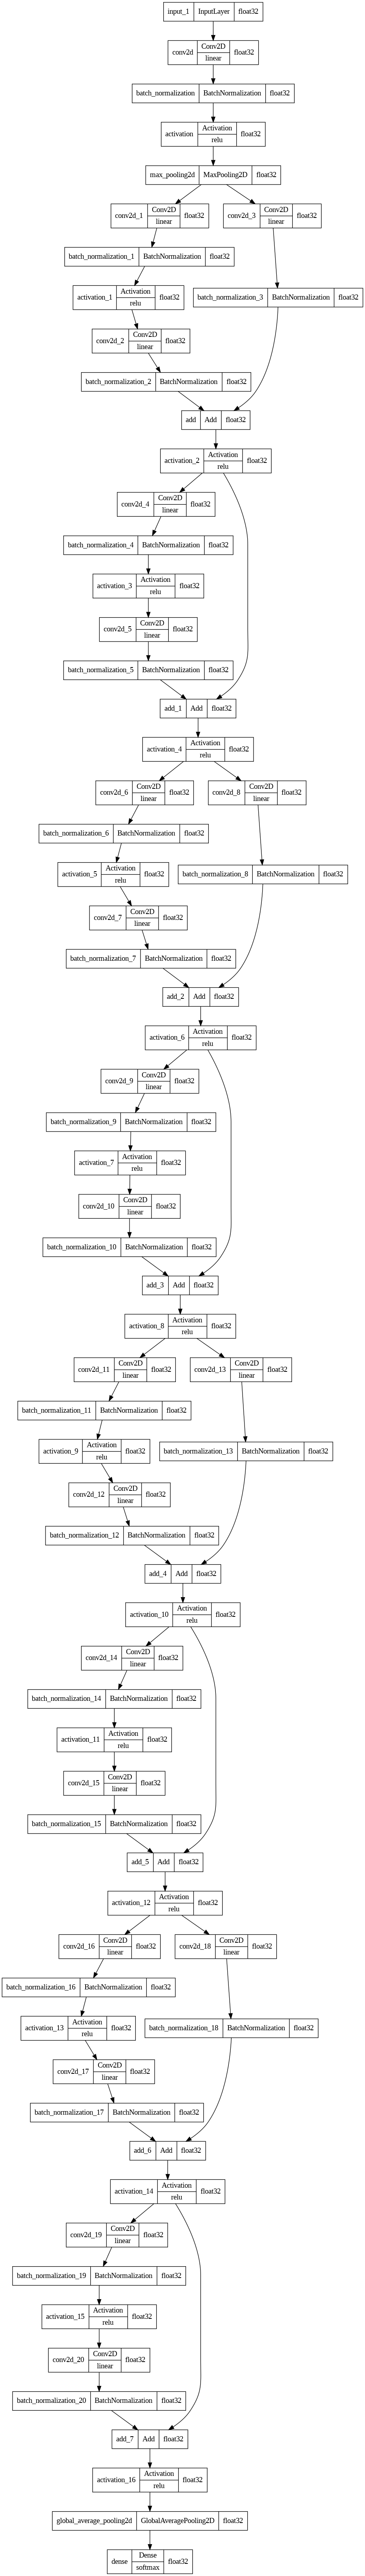

In [8]:
plot_model(model ,  show_layer_names = True , show_layer_activations=True , show_dtype = True)

In [9]:
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

In [10]:
model.fit(x_train , y_train , epochs = 5 , batch_size = 10)

Epoch 1/5
5000/5000 [==============================] - 120s 19ms/step - loss: 1.7470 - accuracy: 0.3908
Epoch 2/5
5000/5000 [==============================] - 96s 19ms/step - loss: 1.2864 - accuracy: 0.5567
Epoch 3/5
5000/5000 [==============================] - 97s 19ms/step - loss: 1.0286 - accuracy: 0.6477
Epoch 4/5
5000/5000 [==============================] - 96s 19ms/step - loss: 0.8670 - accuracy: 0.7044
Epoch 5/5
5000/5000 [==============================] - 96s 19ms/step - loss: 0.7383 - accuracy: 0.7469


In [11]:
model.evaluate(x_test , y_test , batch_size = 1)

10000/10000 [==============================] - 54s 5ms/step - loss: 0.8527 - accuracy: 0.7099


[0.8527123332023621, 0.7099000215530396]